In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def unpack_torch(trellis_swizzled):
    shifter_8bit = torch.arange(0, 4, device="cuda") * 8
    shifter_4bit = torch.arange(0, 4, device="cuda") * 4
    mask_8bit = 0xFF
    mask_4bit = 0xF

    trellis_swizzled = trellis_swizzled.reshape(
        trellis_swizzled.shape[0], 64, -1
    )

    B0, B1 = trellis_swizzled.shape[0], trellis_swizzled.shape[2]

    # blocks_trellis = trellis_swizzled[:blocks[0], :, :blocks[1]]
    # [B0, 64, B1]

    b_packed_even = trellis_swizzled[:, 0:32, :]
    b_packed_odd = trellis_swizzled[:, 32:64, :]

    # print("b_packed_even", b_packed_even)
    # print("b_packed_odd", b_packed_odd)
    # [B0, 32, B1], [B0, 32, B1]

    # print(b_packed_even)
    # print(b_packed_odd[0, :, 0])

    b_packed_even_next = torch.roll(b_packed_even, dims=1, shifts=-1)
    b_packed_even_roll = ((b_packed_even >> 8) & 0xFFFFFF) | ((b_packed_even_next & 0xFF) << 24)

    bytes_even = (b_packed_even[:,:,:, None] >> shifter_8bit[None,None,None, :]) & mask_8bit
    bytes_even_rolled = (b_packed_even_roll[:,:,:, None] >> shifter_8bit[None,None,None, :]) & mask_8bit
    bytes_odd = (b_packed_odd[:,:,:, None] >> shifter_8bit[None,None,None, :]) & mask_8bit
    # [B0, 32, B1, 4], [B0, 32, B1, 4]

    codes_even = bytes_even << 8 | bytes_odd
    codes_odd = bytes_odd << 8 | bytes_even_rolled
    # [B0, 32, B1, 4], [B0, 32, B1, 4]

    codes = torch.stack([codes_even, codes_odd], dim=-1).reshape(B0, 32, B1, 8)
    # [B0, 32, B1, 8]

    codes = ((codes.to(torch.int32) * 34038481) >> 9) & 0xFFFF

    vals = (codes[:, :, :, :, None] >> shifter_4bit[None, None, None, None, :]) & mask_4bit
    # [B0, 32, B1, 8, 4]

    vals = vals.reshape(B0 * 32, B1 * 32)
    
    # for i in range(vals.shape[0]):
    #     print(vals[i].cpu().numpy())

    return vals


# trellis = torch.randint(-2**31, 2**31, (K // 32, N * 2), device="cuda")
# trellis_swizzled = trellis.reshape(
#     K // 32,
#     N * 2 // 64,
#     64
# ).transpose(1,2).contiguous().reshape(K // 32, N * 2)
# matrix = unpack_torch(trellis_swizzled)

In [3]:
def get_cuda_autotune_config():
    configs = []
    for num_warps in [4]:
        for num_stages in [2,3,4]:
            for BLOCK_SIZE_M in [16]:
                for BLOCK_SIZE_N in [32, 64, 128]:
                    for BLOCK_SIZE_K in [128, 256, 512]:
                        configs.append(
                            triton.Config(
                                {
                                    "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                    "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                    "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                                },
                                num_warps=num_warps,
                                num_stages=num_stages, 
                            ),
                        )
    return configs

    configs = []
    for num_warps in [4]:
        for num_stages in [4]:
            configs.append(
                                triton.Config(
                                    {
                                        "BLOCK_SIZE_M" : 16,
                                        "BLOCK_SIZE_N" : 64,
                                        "BLOCK_SIZE_K" : 64,
                                    },
                                    num_warps=num_warps,
                                    num_stages=num_stages, 
                                ),
                            )
    return configs

In [4]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit()
def test_trellis_kernel(
        a_ptr, stride_am, stride_ak,
        b_ptr, stride_bk, stride_lane, stride_bn,
        c_ptr, stride_cm, stride_cn,
        M, N, K,
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    grid_n = tl.cdiv(N, BLOCK_SIZE_N)
    pid_m = 0
    pid_n = pid % grid_n

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_ak = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_ak[None, :] * stride_ak)

    offs_bk = tl.arange(0, BLOCK_SIZE_K // 32)
    offs_lane = tl.arange(0, 32)
    offs_nb = tl.arange(0, BLOCK_SIZE_N // 32)
    offs_nb_even = pid_n * BLOCK_SIZE_N // 32 + offs_nb
    offs_nb_odd = pid_n * BLOCK_SIZE_N // 32 + offs_nb + (N // 32)
    
    b_ptrs_even = (
        b_ptr
        + offs_bk[:, None, None]   * stride_bk
        + offs_lane[None, :, None] * stride_lane
        + offs_nb_even[None, None, :] * stride_bn
    )

    b_ptrs_odd = (
        b_ptr
        + offs_bk[:, None, None]   * stride_bk
        + offs_lane[None, :, None] * stride_lane
        + offs_nb_odd[None, None, :] * stride_bn
    )
    
    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    shifter_8bit = tl.arange(0, 4) * 8
    shifter_4bit = tl.arange(0, 4) * 4

    gather_idx = tl.arange(0, 32) + 1
    gather_idx = tl.where((gather_idx % 32) != 0, gather_idx, gather_idx - 32)

    a_mask = (offs_am[:, None] < M) & (offs_ak[None, :] < K)
    a = tl.load(a_ptrs, mask=a_mask, other=0.0, eviction_policy="evict_last")
    
    b_even_next = (offs_bk[:, None] < tl.cdiv(K, 32))
    b_odd_next = (offs_bk[:, None] < tl.cdiv(K, 32))
    b_packed_even = tl.load(b_ptrs_even)#, mask=b_even_next, other=0)
    b_packed_odd = tl.load(b_ptrs_odd)#, mask=b_odd_next, other=0)
    # [B0, 32, B1]

    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_mask_next = (offs_am[:, None] < M) & (offs_ak[None, :] + next_k_offset < K)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_mask_next, other=0.0, eviction_policy="evict_last")

            b_even_next_mask = (offs_bk[:, None] + next_k_offset // 32 < tl.cdiv(K, 32))
            b_odd_next_mask = (offs_bk[:, None] + next_k_offset // 32 < tl.cdiv(K, 32))
            b_packed_even_next = tl.load(b_ptrs_even + (next_k_offset // 32) * stride_bk)#, mask=b_even_next_mask, other=0)
            b_packed_odd_next = tl.load(b_ptrs_odd + (next_k_offset // 32) * stride_bk)#, mask=b_odd_next_mask, other=0)
            # [B0, 32, B1]
        else:
            a_next = tl.zeros_like(a)
            b_packed_even_next = tl.zeros_like(b_packed_even)
            b_packed_odd_next = tl.zeros_like(b_packed_odd)

        b_packed_even_shifted = tl.gather(
            src = b_packed_even,
            index = gather_idx[None, :, None].broadcast_to(b_packed_even.shape),
            axis=1
        )
        b_packed_even_roll = ((b_packed_even >> 8) & 0xFFFFFF) | ((b_packed_even_shifted & 0xFF) << 24)
        # [B0, 32, B1]
        
        bytes_even = (b_packed_even[:,:,:,None] >> shifter_8bit[None,None,None,:]) & 0xFF
        bytes_even_rolled = (b_packed_even_roll[:,:,:,None] >> shifter_8bit[None,None,None,:]) & 0xFF
        bytes_odd = (b_packed_odd[:,:,:,None] >> shifter_8bit[None,None,None,:]) & 0xFF
        # [B0, 32, B1, 4]
        
        codes_even = bytes_even << 8 | bytes_odd
        codes_odd = bytes_odd << 8 | bytes_even_rolled
        # [B0, 32, B1, 4]
        
        codes = tl.join(codes_even, codes_odd)
        codes = ((codes.to(tl.uint32) * 34038481) >> 9) & 0xFFFF
        # [B0, 32, B1, 4, 2]

        vals = (codes[:, :, :, :, :, None] >> shifter_4bit[None, None, None, None, None, :]) & 0xF
        # [B0, 32, B1, 4, 2, 4]

        b = vals.reshape(BLOCK_SIZE_K, BLOCK_SIZE_N).to(tl.float16)
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        # Advance the ptrs to the next K block.
        a = a_next
        b_packed_even = b_packed_even_next
        b_packed_odd = b_packed_odd_next


    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def test_trellis_triton(a, b):
    assert a.shape[1] == b.shape[0] * 32, "Incompatible dimensions"

    M, K = a.shape
    N = b.shape[2] * 16
    
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )

    test_trellis_kernel[grid](
        a, a.stride(0), a.stride(1),
        b, b.stride(0), b.stride(1), b.stride(2),
        c, c.stride(0), c.stride(1),
        M, N, K
    )
    return c

In [5]:
@torch.no_grad()
def deepseek_dist(x, y):
    x, y = x.double(), y.double()
    denom = (x * x + y * y).sum()
    sim = 2 * (x * y).sum() / denom
    return 1 - sim


def test_out(M, K, N):
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K) ** 0.5
    trellis = torch.randint(-2**31, 2**31, (K // 32, N * 2), device="cuda")
    trellis_swizzled = trellis.reshape(
        K // 32,
        N // 32,
        64
    ).transpose(1,2).contiguous().reshape(K // 32, N * 2)
    matrix = unpack_torch(trellis_swizzled).to(torch.float16)

    torch_out = y_fp16 @ matrix
    triton_out = test_trellis_triton(y_fp16, trellis)
    
    dist = deepseek_dist(torch_out, triton_out)
    print(f"[MxKxN]: [{M}x{K}x{N}] dist: {dist}")
    assert dist < 0.001

In [6]:
# for s in [2**11, 2**12, 2**13, 2**14]:
#     test_out(1, s, s)


[MxKxN]: [1x2048x2048]
trellis_matmul_triton: BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None

[MxKxN]: [1x4096x4096]
trellis_matmul_triton: BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None

[MxKxN]: [1x8192x8192]
trellis_matmul_triton: BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 128, num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None

[MxKxN]: [1x16384x16384]
trellis_matmul_triton: BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 128, BLOCK_SIZE_K: 128, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
matmul-performance:
         K    M        N  torch_fp16  triton_trellis
0   2048.0  1.0   2048.0    0.227260        0.455111
1   4096.0  1.0   4096.0    0.391406        0.785450
2   8192.0  1.0   8192.0    0.606815        1.170286
3  16384.0  1.0  16384.0    0.796488        1.420955


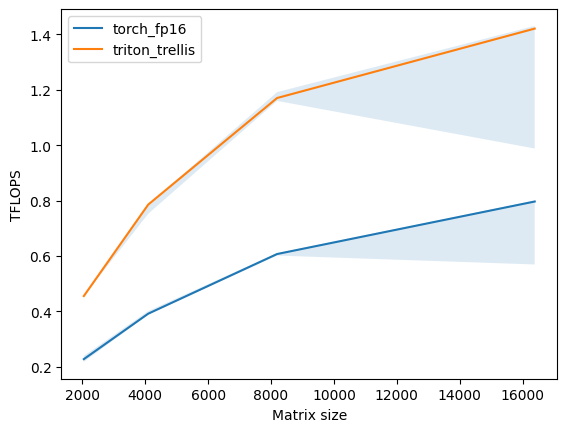

In [7]:
BS = 1
sizes = [2**11, 2**12, 2**13, 2**14]

llama_sizes = [
    (1, 11008, 4096),
    (1, 4096, 11008),
    (1, 4096, 4096),
]

BSs = [1, 16, 32, 128, 1024, 4096]
size = 4096

experiments = [
            "torch_fp16",
            "triton_trellis",
            # "triton_trellis_new",
            # "triton_trellis_",
            # "triton_trellis_old",
            ]

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],
        x_vals=[(size, BS, size) for size in sizes],
        # x_names=["M", "K", "N"],
        # x_vals=llama_sizes,
        # x_names=["M", "K", "N"],
        # x_vals=[(BS, size, size) for BS in BSs],
        # x_log=True,
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        line_vals=experiments,
        line_names=experiments,
        ylabel="TFLOPS",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))

@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda")
    x_fp16 = torch.randn(K, N, dtype=torch.float16, device="cuda")

    x_compressed = torch.randint(-2**31, 2**31, (K//32, 32, 2*(N//32)), dtype=torch.int32, device="cuda")

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        print(f"\n[MxKxN]: [{M}x{K}x{N}]")
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_fp16), quantiles=quantiles)

    if provider == 'triton_trellis':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: test_trellis_triton(y_fp16, x_compressed), quantiles=quantiles)
        print("trellis_matmul_triton:", test_trellis_kernel.best_config)

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

bench_data = benchmark.run(show_plots=False, print_data=True, return_df=True)[0]

In [8]:
def add_speedup_columns(df):
    df_result = df.copy()
    base_column = 'torch_fp16'
    
    new_column_order = []
    
    for column in df.columns:
        new_column_order.append(column)
        if column not in ['K', 'M', 'N', base_column]:
            speedup_column = f"{column}_speedup"
            df_result[speedup_column] = df[column] / df[base_column]
            new_column_order.append(speedup_column)
    df_result = df_result[new_column_order]
    return df_result

add_speedup_columns(bench_data)

,K,M,N,torch_fp16,triton_trellis,triton_trellis_speedup
0,2048.0,1.0,2048.0,0.227260,0.455111,2.002604
1,4096.0,1.0,4096.0,0.391406,0.785450,2.006741
2,8192.0,1.0,8192.0,0.606815,1.170286,1.928571
3,16384.0,1.0,16384.0,0.796488,1.420955,1.784026


In [9]:
# 0	2048.0	1.0	2048.0	0.225792	0.842907	3.733119
# 1	4096.0	1.0	4096.0	0.391406	1.381523	3.529644
# 2	8192.0	1.0	8192.0	0.595951	1.724632	2.893915
# 3	16384.0	1.0	16384.0	0.796488	1.901532	2.387397

In [10]:
# 0	2048.0	1.0	2048.0	0.225792	0.842907	3.733119
# 1	4096.0	1.0	4096.0	0.391406	1.381523	3.529644
# 2	8192.0	1.0	8192.0	0.601248	1.524093	2.534884
# 3	16384.0	1.0	16384.0	0.799524	1.671204	2.090248